<a href="https://colab.research.google.com/github/lcjln/Kaggle_NEWS_Classification/blob/main/Disaster_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#기본 패키지
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
#plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import tensorflow as tf
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [22]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


데이터는 id, keyword, location, text, target 총 5개 변수로 이루어졌음


id : 각 트위터 데이터 식별자


keyword : 해당 트윗의 특정 키워드


location : 트워타가 작성된 장소


text : 실제 트윗의 메시지


target : 트위터가 실제로 재난이라면 1, 가짜라면 0이라고 표시

In [23]:
test.info() # test 데이터에는 target 변수가 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


# 탐색적 자료 분석



---
수치를 예측하는 회귀 문제와 달리 범주를 예측하는 분류 문제에서 가장 중요한 것은 종속 변수 분포 시각화


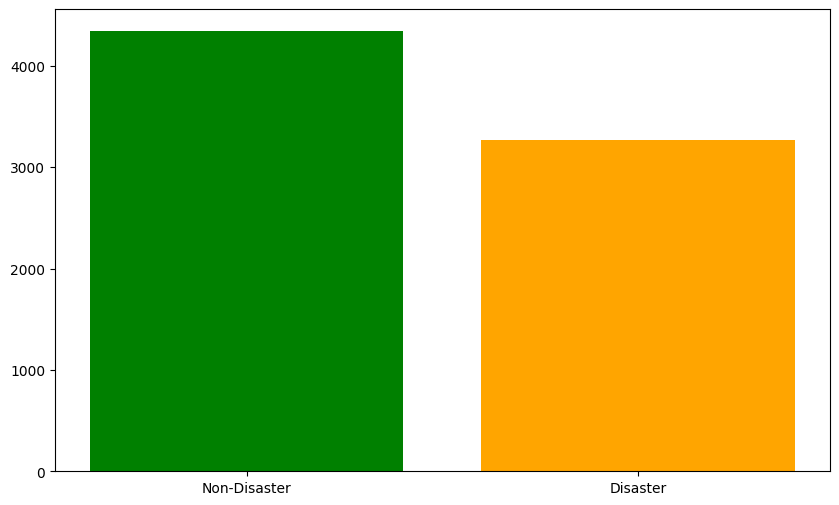

In [24]:
news_class=train['target'].value_counts()
labels = ['Non-Disaster', 'Disaster']

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(labels, news_class, color = ['green','orange'])

fig.show()

캐글에서 보통 분류 문제의 종속 변수는 위 그래프와 같이 데이터 개수가 불균형할 때가 많음

핵심은 이러한 비대칭 데이터를 어떻게 샘플링해 학습시킬 것인가 -> 이를 위해 시각화를 통해 가장 먼저 확인해야함

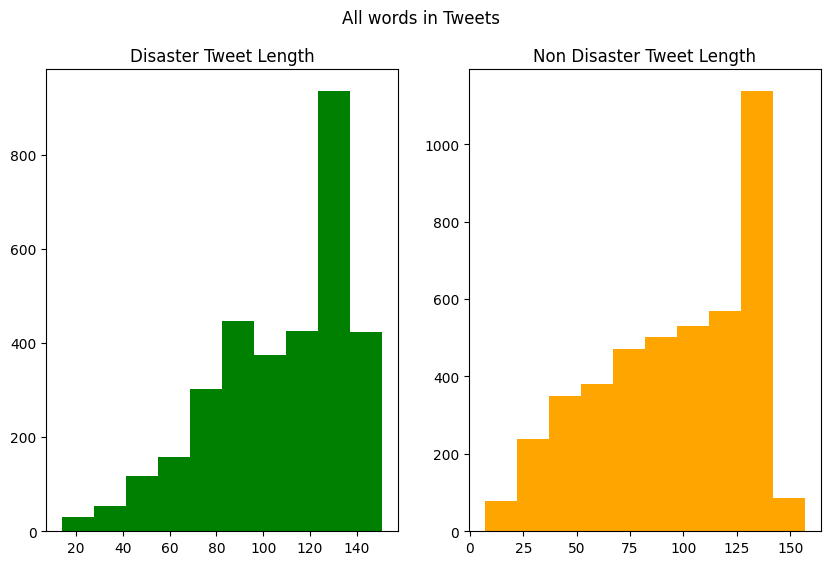

In [25]:
# 독립 변수로 활용할 트윗 데이터 시각화
disaster_tweet_len = train[train['target'] == 1]['text'].str.len()
non_disaster_tweet_len = train[train['target'] == 0]['text'].str.len()

fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(disaster_tweet_len, color='g')
ax[0].set_title('Disaster Tweet Length')

ax[1].hist(non_disaster_tweet_len, color='orange')
ax[1].set_title('Non Disaster Tweet Length')

fig.suptitle("All words in Tweets")
plt.show()

두 개의 그래프 모두 비슷한 분포를 보이나 길이가 140을 넘어가면 Non Disaster가 급격하게 떨어짐을 알 수 있음

/tmp/ipython-input-26-1458516482.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot(disaster_tweet_len, labels=['counts'], showmeans = True) #showmeans 파라미터는 평균값을 그래프에 삼각형 모양으로 표시함
/tmp/ipython-input-26-1458516482.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot(non_disaster_tweet_len, labels=['counts'], showmeans = True)


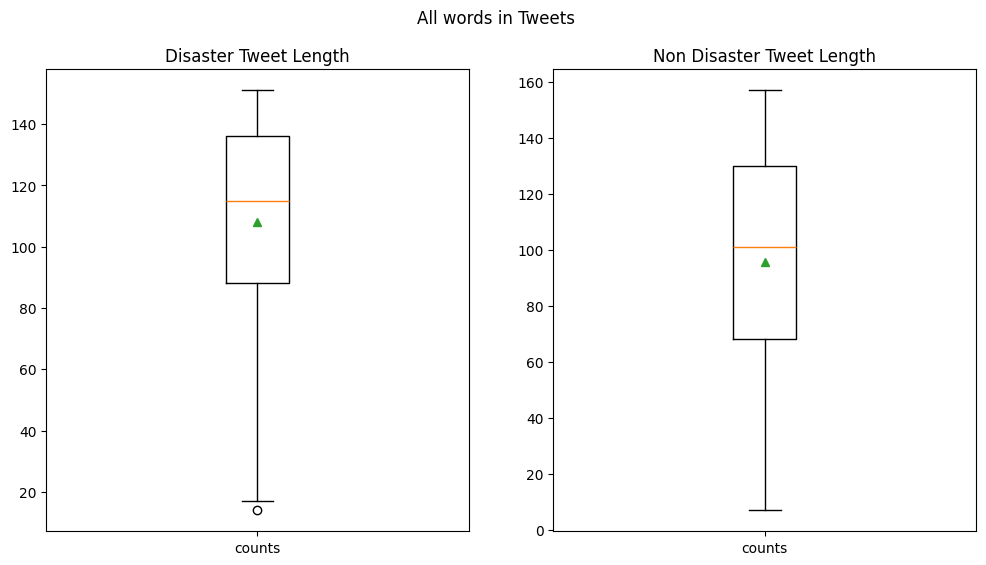

In [26]:
# 양 그래프의 글자 수를 박스 플롯을 통해 비교
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].boxplot(disaster_tweet_len, labels=['counts'], showmeans = True) #showmeans 파라미터는 평균값을 그래프에 삼각형 모양으로 표시함
ax[0].set_title("Disaster Tweet Length")

ax[1].boxplot(non_disaster_tweet_len, labels=['counts'], showmeans = True)
ax[1].set_title("Non Disaster Tweet Length")

fig.suptitle("All words in Tweets")
plt.show()

두 데이터 모두 중간값보다는 작은 값을 나타냄을 알 수 있음

전반적으로 Disaster 트윗 문장 길이가 Non Disaster 트윗의 글자 수보다 많은 것을 확인할 수 있음

In [27]:
# 워드클라우드를 이용하여 데이터 빈도수 확인

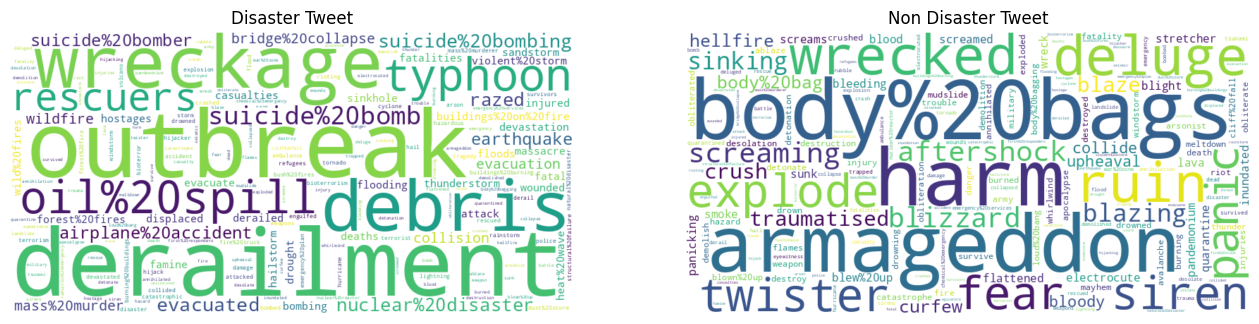

In [28]:
from wordcloud import WordCloud, STOPWORDS

disaster_tweet_keywords = dict(train[train['target'] == 1]['keyword'].value_counts())
non_disaster_tweet_keywords = dict(train[train['target'] == 0]['keyword'].value_counts())

stopwords = set(STOPWORDS)
disaster_wordcloud = WordCloud(stopwords=stopwords, width = 800, height = 400, background_color="white").generate_from_frequencies(disaster_tweet_keywords)
non_disaster_wordcloud = WordCloud(stopwords=stopwords, width = 800, height = 400, background_color="white").generate_from_frequencies(non_disaster_tweet_keywords)

fig, ax = plt.subplots(1,2, figsize=(16,10))
ax[0].imshow(disaster_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Disaster Tweet')

ax[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Non Disaster Tweet')
fig.show()

Disaster 트윗은 Typhoon, Wreckage, Outbreak, Derailment 등 명사 하나로도 충분히 설명되지만

Non Disaster 트윗은 명사보다는 주로 형용사나 동사가 주로 사용됨

# 피처 엔지니어링 - 텍스트 데이터

텍스트 데이터는 전처리해야할 과정이 다른 정형 데이터보다 더 많음


결측치 확인

In [29]:
#결측치 비율 확인 사용자 함수
def check_na(data):
    isnull_na = ((data.isnull().sum())/(len(data)))*100 # 파라미터에 적힌 데이터프레임에서 결측치를 확인하여 백분율로 표현함
    data_na = isnull_na.drop(isnull_na[isnull_na==0].index).sort_values(ascending=False) # 결측치가 없는 시리즈는 제거하여 내림차순으로 결측치 비율을 구함
    missing_data = pd.DataFrame({'Missing Ratio' :data_na,
                                 'Data Type' : data.dtypes[data_na.index]})
    print("결측치 데이터 칼럼과 건수:\n", missing_data)

In [30]:
check_na(train)
check_na(test)

결측치 데이터 칼럼과 건수:
           Missing Ratio Data Type
location      33.272035    object
keyword        0.801261    object
결측치 데이터 칼럼과 건수:
           Missing Ratio Data Type
location      33.864542    object
keyword        0.796813    object


In [31]:
# id는 따로 추출하고 결측치 값인 locaion과 keyword와 함께 제거
test_id = test['id']
for i in [train, test]: # 데이터프레임도 리스트로 묶어서 for문으로 출력가능
    i = i.drop(['id', 'location','keyword'], axis = 1, inplace = True)

print(train.shape)
print(test.shape)

(7613, 2)
(3263, 1)


# 텍스트 전처리 함수 만들기



---


웹 크롤링 이후 이모티콘과 #과 같은 태크고 제거해야함 이를 한꺼번에 처리하는 전처리 함수 제작

- url에 대항하는 문자 삭제
- html 태그에 해당하는 문자 삭제
- 이모티콘 삭제
- 특수문자들을 공백으로 변경
- 구두점과 같은 기호 삭제
- 영어 대문자들을 소문자로 변환
- 불용어 제거

택스트 마이닝은 텍스트 전처리 함수에 얼마나 공을 들이느냐에 따라 성능이 좌우될만큼 중요함

In [32]:
import string
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
# 텍스트 전처리 사용자 함수
def data_cleansing(text, remove_stopwords=False):
    #remove url
    url = re.compile(r'https?://\S+|www\.\S+')
    cleaned_text=url.sub(r'',text)

    #remove html tag
    html=re.compile(r'<.*?>')
    cleaned_text=html.sub('',cleaned_text)

    #remove emoji
    emoji_pattern=re.compile("["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    u"\U00012702-\U000127B0"
    u"\U000124C2-\U0001F251"
    "]+", flags = re.UNICODE)
    cleaned_text = emoji_pattern.sub(r'', cleaned_text)

    #Special Letters to empty space
    cleaned_text=re.sub(r"[^a-zA-Z]","",cleaned_text)

    #remove Punctuation
    table = str.maketrans('','', string.punctuation) #maketrans(x,y,z) x문자를 y로 치환(길이는 같아야함), z는 삭제 // string.punctuation -> 문장 부호를 의미
    cleaned_text=cleaned_text.translate(table)

    #Lowercase
    cleaned_text = cleaned_text.lower().split()

    if remove_stopwords:
        stops = set(stopwords.words("english"))
        cleaned_text = [word for word in cleaned_text if not word in stops]
        clean_review = ' '.join(cleaned_text)
    else:
        clean_review = ' '.join(cleaned_text)

    return clean_review

for datas in [train, test]:
    datas['cleaned_text'] = datas['text'].apply(lambda x: data_cleansing(x, remove_stopwords=True))

In [34]:
train.head()
train.shape

(7613, 3)

# 특징 추출 -TFIDF

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
vectorizer = TfidfVectorizer(
    min_df=0.0, #단어가 문서에 등장하는 최소 비율→ 0.0이면 모든 문자 n-gram 사용 (실제로는 0.0은 의미 없음, 일반적으로 min_df=1 이상 사용)
    analyzer = 'char', #분석 단위를 문자(char) 단위로 설정 ex) "hello" → ['h', 'he', 'hel', ...]
    sublinear_tf = True, #TF(term frequency)를 스무딩하여 1 + log(tf)로 변환→ 아주 많이 등장하는 n-gram의 영향력 완화
    ngram_range=(1,3), #1~3글자짜리 문자 n-gram 생성예: h, he, hel, e, el, ell, …
    max_features = 12000) #가장 중요한 12,000개의 n-gram만 사용→ 희소 행렬의 차원 수를 제한해 계산 속도 향상 및 과적합 방지

X = vectorizer.fit_transform(train['cleaned_text']).toarray()
y = train['target'].values
print(X.shape)
print(y.shape)

(7613, 10672)
(7613,)


In [40]:
# 학습 데이터 정의
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((5329, 10672), (2284, 10672), (5329,), (2284,))

In [43]:
#로지스틱 회귀모델 정의
from sklearn.linear_model import LogisticRegression
lgs = LogisticRegression(class_weight='balanced')
lgs.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [45]:
X_testset = vectorizer.transform(test['cleaned_text']).toarray()
print("The Shape of Test Dataset:", X_testset.shape)

y_test_pred = lgs.predict(X_testset)
print("The Predict Value:", y_test_pred)

y_test_pred = np.where(y_test_pred>= 0.5, 1, 0)
print("The Predict Class", y_test_pred)

submission_file = pd.DataFrame({'id':test_id, 'target':y_test_pred})
print(submission_file.head())

submission_file.to_csv('submission_lgs_file.csv', index=False)

The Shape of Test Dataset: (3263, 10672)
The Predict Value: [1 0 1 ... 1 1 1]
The Predict Class [1 0 1 ... 1 1 1]
   id  target
0   0       1
1   2       0
2   3       1
3   9       1
4  11       1
